*Keywords:* Loan Default, Python, Machine Learning, Predictive Modeling, Logistic Regression, Random Forest, Decision Tree, Correlation Matrix

## Project Overview and Objectives

**Resaerch Question:** 

Could the occurence of natural disasters, as witness in the United States from 2012 to 2019, be used as a predictor for loans defaults?

**Alternative Hypothesis (H1):** 

Suggests that the occurence of natural disasters in the United States from 2012-2019 is a significant predictor for loan default.

**Null Hypothesis (H0):** 

Suggests that the occurence ofnatural disasters in the United States from 2012 to 2019 has no predictive power for loan defualts.

**Methodology**

This project is an extension to the "Predicting What Features Influence Loan Default" notebook. It employs a structured methodology consisting of several key stages: data cleaning, Exploratory Data Analysis (EDA), feature engineering, and feature selection. Following those steps, predictive modeling is conducted utilizing Logistic Regression, Random Forest, and Decision Tree algorithms. Finally, the project culminates with a comprehensive feature importance analysis, using techniques such as Confusion Matrix and ROC Curve evaluation. 

**Dataset:**
- Lending Club Loan Data; located on Kaggle
- US Natural Disaters Declarations; located on Kaggle

**First research question to this project:** Analyzing what factors influence loan default in the U.S. Located on Kaggle "Predicting Factors Influencing Loan Default in U.S"

[Kaggle.com: rosaaestrada - Predicting Factors Influencing Loan Default in U.S](https://www.kaggle.com/code/rosaaestrada/predicting-factors-influencing-loan-default-in-u-s)

## Importing the data

In [1]:
#Import libaries
%matplotlib inline

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
#Loading loan dataset
df_loan = pd.read_csv('/kaggle/input/lending-club-loan-data-csv/loan.csv', low_memory = False)

In [3]:
#Select features
cols = ['last_pymnt_amnt', 'total_rec_prncp', 'last_pymnt_d', 'loan_status']

df_loan = df_loan[cols]
df_loan.head(5)

,last_pymnt_amnt,total_rec_prncp,last_pymnt_d,loan_status
0,84.92,113.98,Feb-2019,Current
1,777.23,612.25,Feb-2019,Current
2,180.69,212.79,Feb-2019,Current
3,146.51,168.07,Feb-2019,Current
4,731.78,660.98,Feb-2019,Current


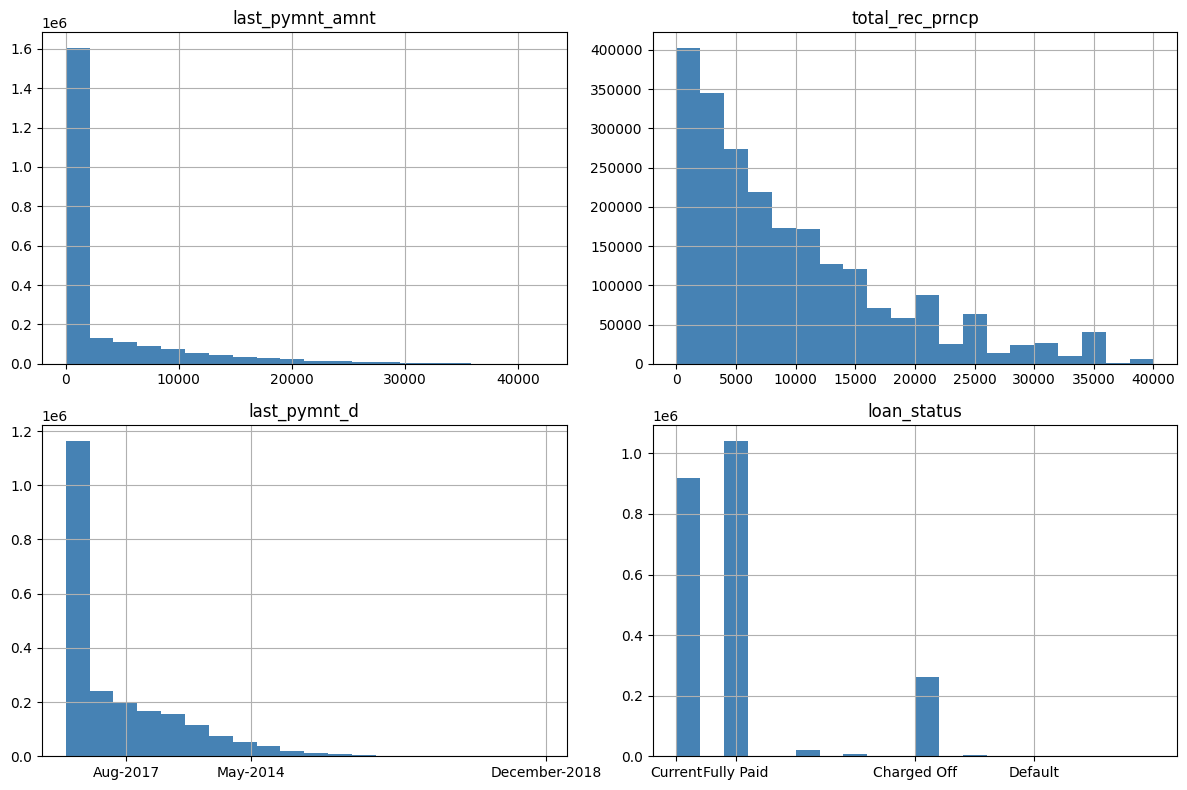

In [4]:
# Set the size of the plot
plt.figure(figsize=(12, 8))

# Define selected categories for specific variables
selected_ticks = {
    'last_pymnt_d': ['Aug-2017', 'December-2018', 'May-2014'],
    'loan_status': ['Current', 'Fully Paid', 'Charged Off', 'Default']
}

# Iterate through each variable and create a histogram
for i, col in enumerate(df_loan.columns):
    plt.subplot(2, 2, i+1)  # Create subplots in a 2x2 grid
    df_loan[col].hist(color='steelblue', bins=20)  # Create histogram
    plt.title(col)  # Set title for each subplot
    
    # Show only selected categories for specific variables
    if col in selected_ticks:
        plt.xticks(selected_ticks[col])  # Show selected category names under the plots
    else:
        plt.xticks(rotation=0)  # Rotate category names for better readability

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [5]:
df_loan.shape

(2260668, 4)

# Data Cleaning

## Missing Values

In [6]:
#Checking missing values and their percentage
missing_values = df_loan.isnull().sum()
missing_percentage = (missing_values / len(df_loan)) * 100

#Combining both into a DataFrame
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

missing_df

,Missing Values,Percentage
last_pymnt_amnt,0,0.000000
total_rec_prncp,0,0.000000
last_pymnt_d,2426,0.107313
loan_status,0,0.000000


In [7]:
#Imputing with the most frequent value(mode)
df_loan['last_pymnt_d'].fillna(df_loan['last_pymnt_d'].mode()[0], inplace=True)

/tmp/ipykernel_18/994291755.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_loan['last_pymnt_d'].fillna(df_loan['last_pymnt_d'].mode()[0], inplace=True)


In [8]:
#list numeric features along with their statistical description
des = df_loan.select_dtypes(exclude=['object']).describe().round(decimals=2).transpose()
print(des.to_string())

                     count     mean      std  min      25%      50%       75%       max
last_pymnt_amnt  2260668.0  3364.02  5971.76  0.0   308.64   588.47   3534.96  42192.05
total_rec_prncp  2260668.0  9300.14  8304.89  0.0  2846.18  6823.38  13397.50  40000.00


array([[<Axes: title={'center': 'last_pymnt_amnt'}>,
        <Axes: title={'center': 'total_rec_prncp'}>],
       [<Axes: >, <Axes: >]], dtype=object)

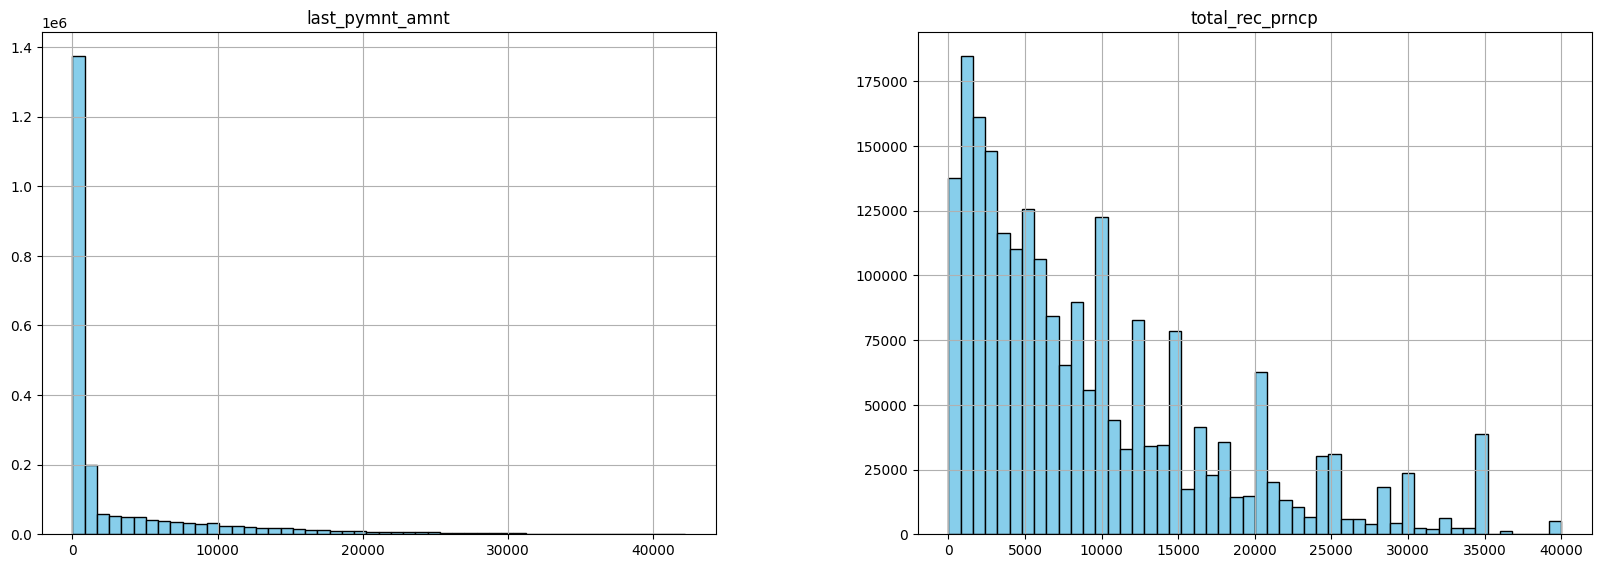

In [9]:
#Plotting histograms
df_loan[['last_pymnt_amnt', 'total_rec_prncp']].hist(bins=50, figsize=(20, 15), layout=(2,2), color='skyblue', 
                                                     edgecolor='black')

In [10]:
#Find the 25 and 75 percentiles
q1, q3 = np.percentile(df_loan['last_pymnt_amnt'],[25, 75])

#Find the IQR and the cutoffs for the outliers
IQR = q3 - q1
lowerOutliers= q1 - 1.5*IQR  
upperOutliers= q3 + 1.5*IQR   
print(lowerOutliers, upperOutliers)

-4530.8475 8374.4525


In [11]:
#Drop outliers in last_pymnt_amnt
df_loan = df_loan[df_loan['last_pymnt_amnt'] < 8374.4525 ]

## Check Duplicate Rows

In [12]:
#check if there are some duplicate rows
number_of_duplicates = df_loan.duplicated().sum()

print(f"Number of duplicate rows: {number_of_duplicates}")

Number of duplicate rows: 619139


In [13]:
df_loan.drop_duplicates(inplace=True)

In [14]:
df_loan.shape

(1315490, 4)

# Exploratory Data Analysis (EDA)

## Target Variable Analysis

In [15]:
#Drop other classes for the target variable
df_loan = df_loan[df_loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]

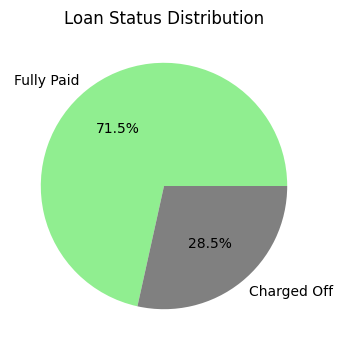

In [16]:
#Bar chart for target variable loan_status
loan_status_counts = df_loan['loan_status'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(loan_status_counts.values, labels=loan_status_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'grey'])
plt.title('Loan Status Distribution')
plt.show()  

### Target Variable Imbalance

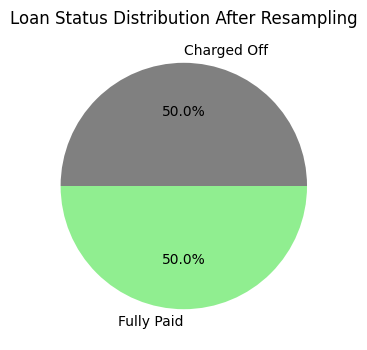

In [17]:
#Separate features and target variable
X = df_loan.drop('loan_status', axis=1)
y = df_loan['loan_status']

#Initialize and fit to the data
rus = RandomUnderSampler(random_state = 123)
X_resampled, y_resampled = rus.fit_resample(X, y)

#Plot the pie chart
loan_status_resampled_counts = y_resampled.value_counts()

plt.figure(figsize=(8, 4))
plt.pie(loan_status_resampled_counts, labels=loan_status_resampled_counts.index, autopct='%1.1f%%',
        colors=['grey', 'lightgreen'])
plt.title('Loan Status Distribution After Resampling')
plt.show()

In [18]:
#Combine X_resampled and y_resampled back into a new DataFrame
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

#Verify
print(resampled_df['loan_status'].value_counts())

loan_status
Charged Off    253270
Fully Paid     253270
Name: count, dtype: int64


In [19]:
#Re-label target variable: 'fully paid' to 0 and 'charged off' to 1
resampled_df['loan_status'] = resampled_df['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})

/tmp/ipykernel_18/797273918.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resampled_df['loan_status'] = resampled_df['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})


In [20]:
#Verify
resampled_df['loan_status'].value_counts()

loan_status
1    253270
0    253270
Name: count, dtype: int64

In [21]:
df1 = resampled_df.copy()

### Categorical Variables

In [22]:
df1['last_pymnt_d'].unique()

array(['Feb-2019', 'Dec-2018', 'Jan-2019', 'Nov-2018', 'Oct-2018',
       'Sep-2018', 'Aug-2018', 'Jul-2018', 'Jun-2018', 'May-2018',
       'Apr-2018', 'Mar-2018', 'Feb-2018', 'Oct-2017', 'Aug-2017',
       'Dec-2017', 'Nov-2017', 'Mar-2017', 'Sep-2017', 'May-2017',
       'Apr-2017', 'Jun-2017', 'Jan-2018', 'Jan-2017', 'Dec-2016',
       'Jul-2017', 'Feb-2017', 'Nov-2016', 'Oct-2016', 'Sep-2016',
       'Aug-2016', 'Jul-2016', 'Jun-2016', 'May-2016', 'Apr-2016',
       'Mar-2016', 'Feb-2016', 'Jan-2016', 'Dec-2015', 'Nov-2015',
       'Oct-2015', 'Sep-2015', 'Aug-2015', 'Jul-2015', 'Jun-2015',
       'May-2015', 'Apr-2015', 'Mar-2015', 'Feb-2015', 'Dec-2014',
       'Nov-2014', 'Apr-2014', 'Mar-2014', 'Jul-2014', 'May-2014',
       'Jan-2015', 'Sep-2014', 'Aug-2014', 'Jun-2014', 'Oct-2014',
       'Feb-2014', 'Jan-2014', 'Dec-2013', 'Nov-2013', 'Oct-2013',
       'Sep-2013', 'Aug-2013', 'Jul-2013', 'Jun-2013', 'May-2013',
       'Apr-2013', 'Mar-2013', 'Feb-2013', 'Jan-2013', 'Dec-20

In [23]:
#Extract
df1['year'] = pd.to_datetime(df1['last_pymnt_d'], format='%b-%Y').dt.year

counts = df1['year'].value_counts().sort_values(ascending=False)
print(counts)

year
2018    147042
2017    138639
2016    100522
2015     59039
2014     27014
2019     13780
2013     11679
2012      5252
2011      2288
2010       895
2009       316
2008        74
Name: count, dtype: int64


In [24]:
#Drop orignal last_pymnt_d columns
df1 = df1.drop(columns=['last_pymnt_d'])

In [25]:
df1 = df1[df1['year'].between(2016, 2018)]

### Focus on the years between 2016-2018

In [26]:
df1.head(5)

,last_pymnt_amnt,total_rec_prncp,loan_status,year
55148,306.97,79.72,1,2018
60604,170.92,103.28,1,2018
62536,1204.23,782.19,1,2018
67928,490.59,356.19,1,2018
68761,765.77,631.19,1,2018


In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386203 entries, 55148 to 1446710
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   last_pymnt_amnt  386203 non-null  float64
 1   total_rec_prncp  386203 non-null  float64
 2   loan_status      386203 non-null  int64  
 3   year             386203 non-null  int32  
dtypes: float64(2), int32(1), int64(1)
memory usage: 13.3 MB


### df_loan dataset is ready for merging

# Load Disaster Dataset

In [28]:
#Loading disaster dataset
df_dis = pd.read_csv('/kaggle/input/us-natural-disaster-declarations/us_disaster_declarations.csv')

In [29]:
df_dis.head(5)

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,last_ia_filing_date,last_refresh,hash,id
0,DR-1-GA,1,GA,DR,1953-05-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-05-02T00:00:00Z,1954-06-01T00:00:00Z,13000,0,Statewide,53013,NaN,2023-03-18T13:22:03Z,48af1afcc4535aa910ddb5b85eebe047dc703a6b,da5c8f17-c28f-4c41-8e06-fa8efc85aa4a
1,DR-2-TX,2,TX,DR,1953-05-15T00:00:00Z,1953,Tornado,Tornado & Heavy Rainfall,0,1,...,1953-05-15T00:00:00Z,1958-01-01T00:00:00Z,48000,0,Statewide,53003,NaN,2023-03-18T13:22:03Z,6bbba411d294ec521683e36313c8da2992e8a857,b0b41f55-0d77-43ac-898c-3cc4a18231e6
2,DR-3-LA,3,LA,DR,1953-05-29T00:00:00Z,1953,Flood,Flood,0,1,...,1953-05-29T00:00:00Z,1960-02-01T00:00:00Z,22000,0,Statewide,53005,NaN,2023-03-18T13:22:03Z,5b2fa18b404bdcf0d3038cd17f1aa995d5412f48,9fd9401d-c76c-43c3-b42a-6a4ae5139ec0
3,DR-4-MI,4,MI,DR,1953-06-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-06-02T00:00:00Z,1956-02-01T00:00:00Z,26000,0,Statewide,53004,NaN,2023-03-18T13:22:03Z,403164346eb22263810402e8b67f1712f1574ad5,67324f38-1f00-4bbc-aeda-5194d1befad6
4,DR-5-MT,5,MT,DR,1953-06-06T00:00:00Z,1953,Flood,Floods,0,1,...,1953-06-06T00:00:00Z,1955-12-01T00:00:00Z,30000,0,Statewide,53006,NaN,2023-03-18T13:22:03Z,8c775d2ce843a8eba2417f9716ba5c75fe0e53f3,e3853916-c7a2-4557-ad8e-60a42d369a61


In [30]:
df_dis.shape

(64092, 23)

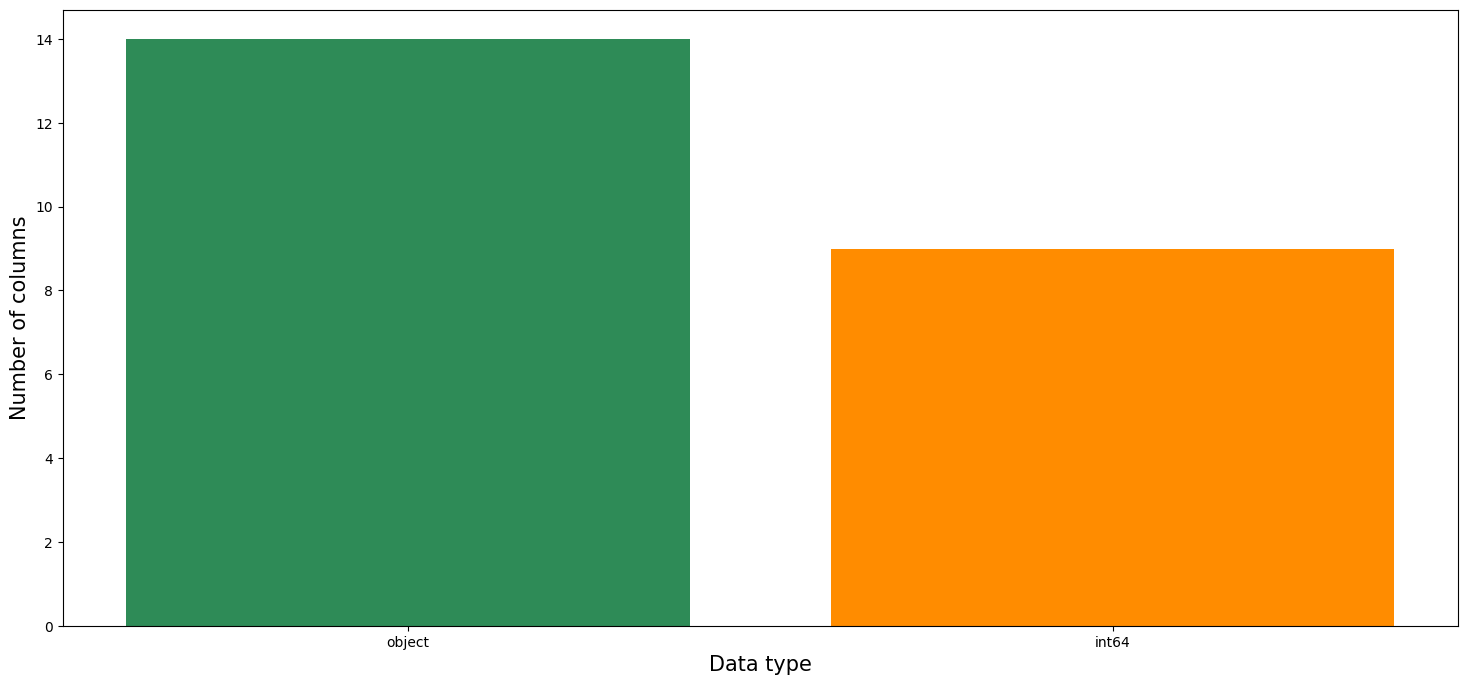

In [31]:
#Numbers of each data type
data_types_count = df_dis.dtypes.value_counts()

#Define color palette as a dictionary
color_palette = {'float64': 'steelblue', 'int64': 'darkorange', 
                 'object': 'seagreen'}

#Get colors for each data type
colors = [color_palette[dt] for dt in data_types_count.index.astype(str)]

plt.figure(figsize=(18,8))
bars = plt.bar(data_types_count.index.astype(str), data_types_count.values, color=colors)
plt.ylabel('Number of columns', fontsize=15)
plt.xlabel('Data type', fontsize=15)

plt.show()

In [32]:
#Print data type counts
data_types_count

object    14
int64      9
Name: count, dtype: int64

In [33]:
df_dis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64092 entries, 0 to 64091
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   fema_declaration_string     64092 non-null  object
 1   disaster_number             64092 non-null  int64 
 2   state                       64092 non-null  object
 3   declaration_type            64092 non-null  object
 4   declaration_date            64092 non-null  object
 5   fy_declared                 64092 non-null  int64 
 6   incident_type               64092 non-null  object
 7   declaration_title           64092 non-null  object
 8   ih_program_declared         64092 non-null  int64 
 9   ia_program_declared         64092 non-null  int64 
 10  pa_program_declared         64092 non-null  int64 
 11  hm_program_declared         64092 non-null  int64 
 12  incident_begin_date         64092 non-null  object
 13  incident_end_date           55682 non-null  ob

In [34]:
df_dis.columns.tolist()

['fema_declaration_string',
 'disaster_number',
 'state',
 'declaration_type',
 'declaration_date',
 'fy_declared',
 'incident_type',
 'declaration_title',
 'ih_program_declared',
 'ia_program_declared',
 'pa_program_declared',
 'hm_program_declared',
 'incident_begin_date',
 'incident_end_date',
 'disaster_closeout_date',
 'fips',
 'place_code',
 'designated_area',
 'declaration_request_number',
 'last_ia_filing_date',
 'last_refresh',
 'hash',
 'id']

## EDA: ND

### Examine Variable 'state'

In [35]:
#Select features
features = ['incident_type', 'incident_begin_date', 'state']

df_dis = df_dis[features]

In [36]:
#check number of values in each state
counts = df_dis['state'].value_counts(ascending=False)

counts

state
TX    5173
MO    2704
KY    2583
VA    2524
LA    2493
OK    2474
FL    2352
GA    2278
NC    2096
PR    1987
MS    1906
IA    1848
KS    1759
AL    1665
TN    1605
CA    1599
AR    1593
MN    1563
NY    1503
NE    1485
IN    1451
SD    1430
ND    1359
IL    1283
OH    1281
PA    1239
WV    1232
ME    1019
WA     979
SC     947
WI     892
MI     796
CO     646
NJ     625
MT     605
OR     586
NM     514
MD     448
MA     398
ID     361
VT     338
AZ     335
AK     318
NH     301
NV     274
CT     255
UT     249
WY     128
RI     114
HI     100
VI      80
AS      76
MP      63
DE      53
MH      53
FM      31
DC      23
GU      19
PW       1
Name: count, dtype: int64

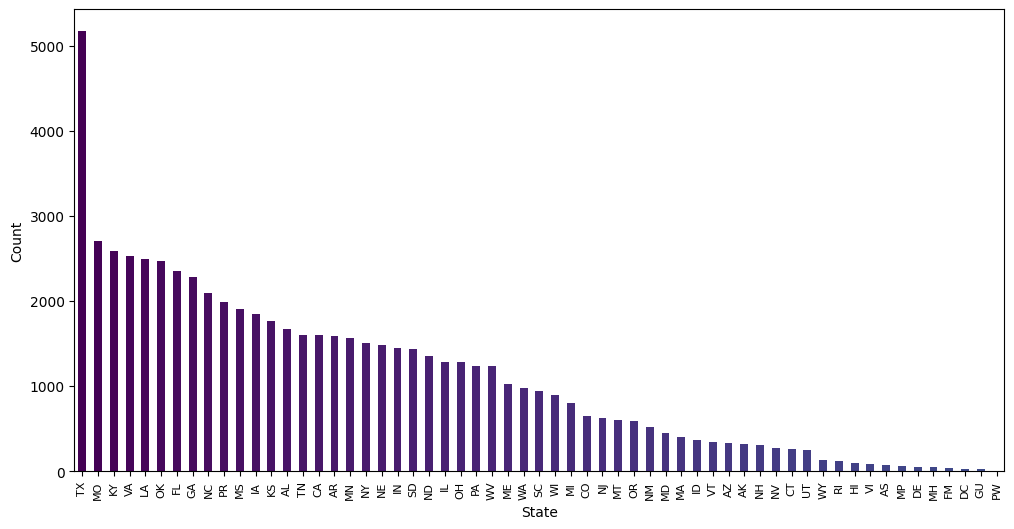

In [37]:
# Extract the counts for each state
counts = df_dis['state'].value_counts(ascending=False)

# Create a custom color palette using 'viridis'
colors = plt.cm.viridis.colors

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Plot the bar plot with the custom color palette
counts.plot(kind='bar', color=colors)

# Set title and labels
plt.xlabel('State')
plt.ylabel('Count')

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=90, fontsize=8)

# Show plot
plt.show()

### Randomly select 6 states with 1,000 or more disaster counts

In [38]:
# set seed for reproducibility
random.seed(42)

# List of categories
categories = ['TX', 'MO', 'KY', 'VA', 'LA', 'OK', 'FL', 
              'GA', 'NC', 'PR', 'MS', 'IA', 'KS', 'AL', 
              'TN', 'CA', 'AR', 'MN', 'NY', 'NE', 'IN', 
              'SD', 'ND', 'IL', 'OH', 'PA', 'WV', 'ME']

# Randomly select a category
random_categories = random.sample(categories, 3)

print("Randomly selected category:", random_categories)

Randomly selected category: ['IN', 'VA', 'TX']


In [39]:
# Filter the DataFrame to retain only the desired categories in the 'state' variable
desired_categories = ['IN', 'VA', 'TX']
df_dis = df_dis[df_dis['state'].isin(desired_categories)]

In [40]:
#check number of values in each type
counts = df_dis['state'].value_counts(ascending=False)

counts

state
TX    5173
VA    2524
IN    1451
Name: count, dtype: int64

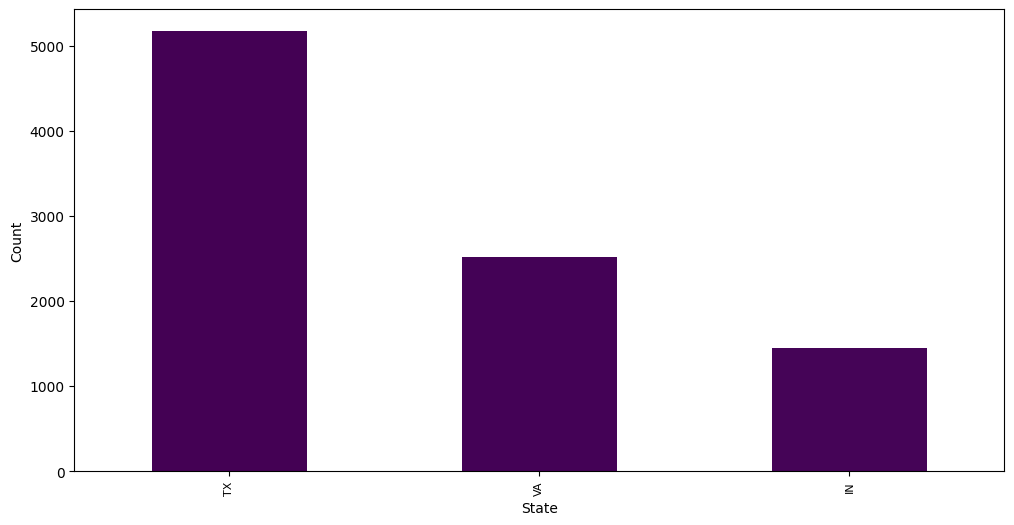

In [41]:
# Extract the counts for each state
counts = df_dis['state'].value_counts(ascending=False)

# Create a custom color palette using 'viridis'
colors = plt.cm.viridis.colors

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Plot the bar plot with the custom color palette
counts.plot(kind='bar', color=colors)

# Set title and labels
plt.xlabel('State')
plt.ylabel('Count')

# Rotate x-axis labels for better readability and increase font size
plt.xticks(rotation=90, fontsize=8)

# Show plot
plt.show()

### Examine Variable 'incident_type'

In [42]:
#check number of values in each type
counts = df_dis['incident_type'].value_counts(ascending=False)

counts

incident_type
Hurricane           2272
Severe Storm        1849
Fire                1236
Flood                992
Biological           976
Snowstorm            688
Severe Ice Storm     613
Drought              249
Tornado              109
Other                 56
Freezing              55
Coastal Storm         42
Earthquake            10
Terrorist              1
Name: count, dtype: int64

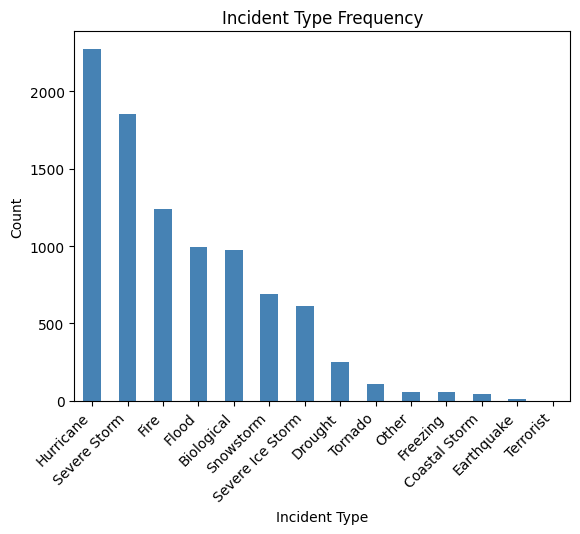

In [43]:
#counts for each category
counts = df_dis['incident_type'].value_counts()

counts.plot(kind='bar', color= 'steelblue')
plt.title('Incident Type Frequency')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Incident Type')
plt.ylabel('Count')
plt.show()

### Examine Variable 'incident_begin_date'

In [44]:
df_dis['incident_begin_date'].unique()

array(['1953-05-15T00:00:00Z', '1953-06-19T00:00:00Z',
       '1954-07-01T00:00:00Z', '1954-10-26T00:00:00Z',
       '1957-02-01T00:00:00Z', '1957-04-29T00:00:00Z',
       '1958-06-06T00:00:00Z', '1959-01-29T00:00:00Z',
       '1959-07-08T00:00:00Z', '1960-07-15T00:00:00Z',
       '1961-05-20T00:00:00Z', '1961-09-16T00:00:00Z',
       '1962-03-09T00:00:00Z', '1963-03-21T00:00:00Z',
       '1963-09-24T00:00:00Z', '1964-03-17T00:00:00Z',
       '1965-04-14T00:00:00Z', '1965-06-19T00:00:00Z',
       '1966-05-12T00:00:00Z', '1966-09-27T00:00:00Z',
       '1967-09-28T00:00:00Z', '1968-06-10T00:00:00Z',
       '1968-07-05T00:00:00Z', '1968-07-30T00:00:00Z',
       '1969-08-23T00:00:00Z', '1970-05-13T00:00:00Z',
       '1970-08-04T00:00:00Z', '1971-09-18T00:00:00Z',
       '1972-01-27T00:00:00Z', '1972-05-20T00:00:00Z',
       '1972-06-23T00:00:00Z', '1972-10-07T00:00:00Z',
       '1972-10-10T00:00:00Z', '1973-03-12T00:00:00Z',
       '1973-06-25T00:00:00Z', '1973-07-11T00:00:00Z',
       '19

In [45]:
#Convert the 'incident_begin_date' to datetime, then extract the year.
df_dis['year'] = pd.to_datetime(df_dis['incident_begin_date']).dt.year

df_dis.drop(columns = ['incident_begin_date'], inplace = True)

In [46]:
df_dis = df_dis[df_dis['year'].between(2016, 2018)]

In [47]:
df_dis.head(5)

,incident_type,state,year
45753,Snowstorm,VA,2016
45754,Snowstorm,VA,2016
45755,Snowstorm,VA,2016
45756,Snowstorm,VA,2016
45757,Snowstorm,VA,2016


In [48]:
df_dis.shape

(465, 3)

# Merge two dataset

In [49]:
#merge with feature year
merged_df = pd.merge(df1, df_dis, on='year')

In [50]:
merged_df.head() #insert state in code above

,last_pymnt_amnt,total_rec_prncp,loan_status,year,incident_type,state
0,306.97,79.72,1,2018,Fire,TX
1,306.97,79.72,1,2018,Fire,TX
2,306.97,79.72,1,2018,Fire,TX
3,306.97,79.72,1,2018,Fire,TX
4,306.97,79.72,1,2018,Flood,IN


In [51]:
merged_df.shape

(61695491, 6)

In [52]:
#check if there are some duplicate rows
number_of_duplicates = merged_df.duplicated().sum()

print(f"Number of duplicate rows: {number_of_duplicates}")

Number of duplicate rows: 60730868


In [53]:
merged_df.drop_duplicates(inplace=True)

In [54]:
#check if there are missing values
merged_df.isnull().sum()

last_pymnt_amnt    0
total_rec_prncp    0
loan_status        0
year               0
incident_type      0
state              0
dtype: int64

## One-hot encoding

In [55]:
merged_df = pd.get_dummies(merged_df, columns=['incident_type', 'state'])

In [56]:
merged_df.shape

(964623, 11)

## Correlation Matrix Heatmap

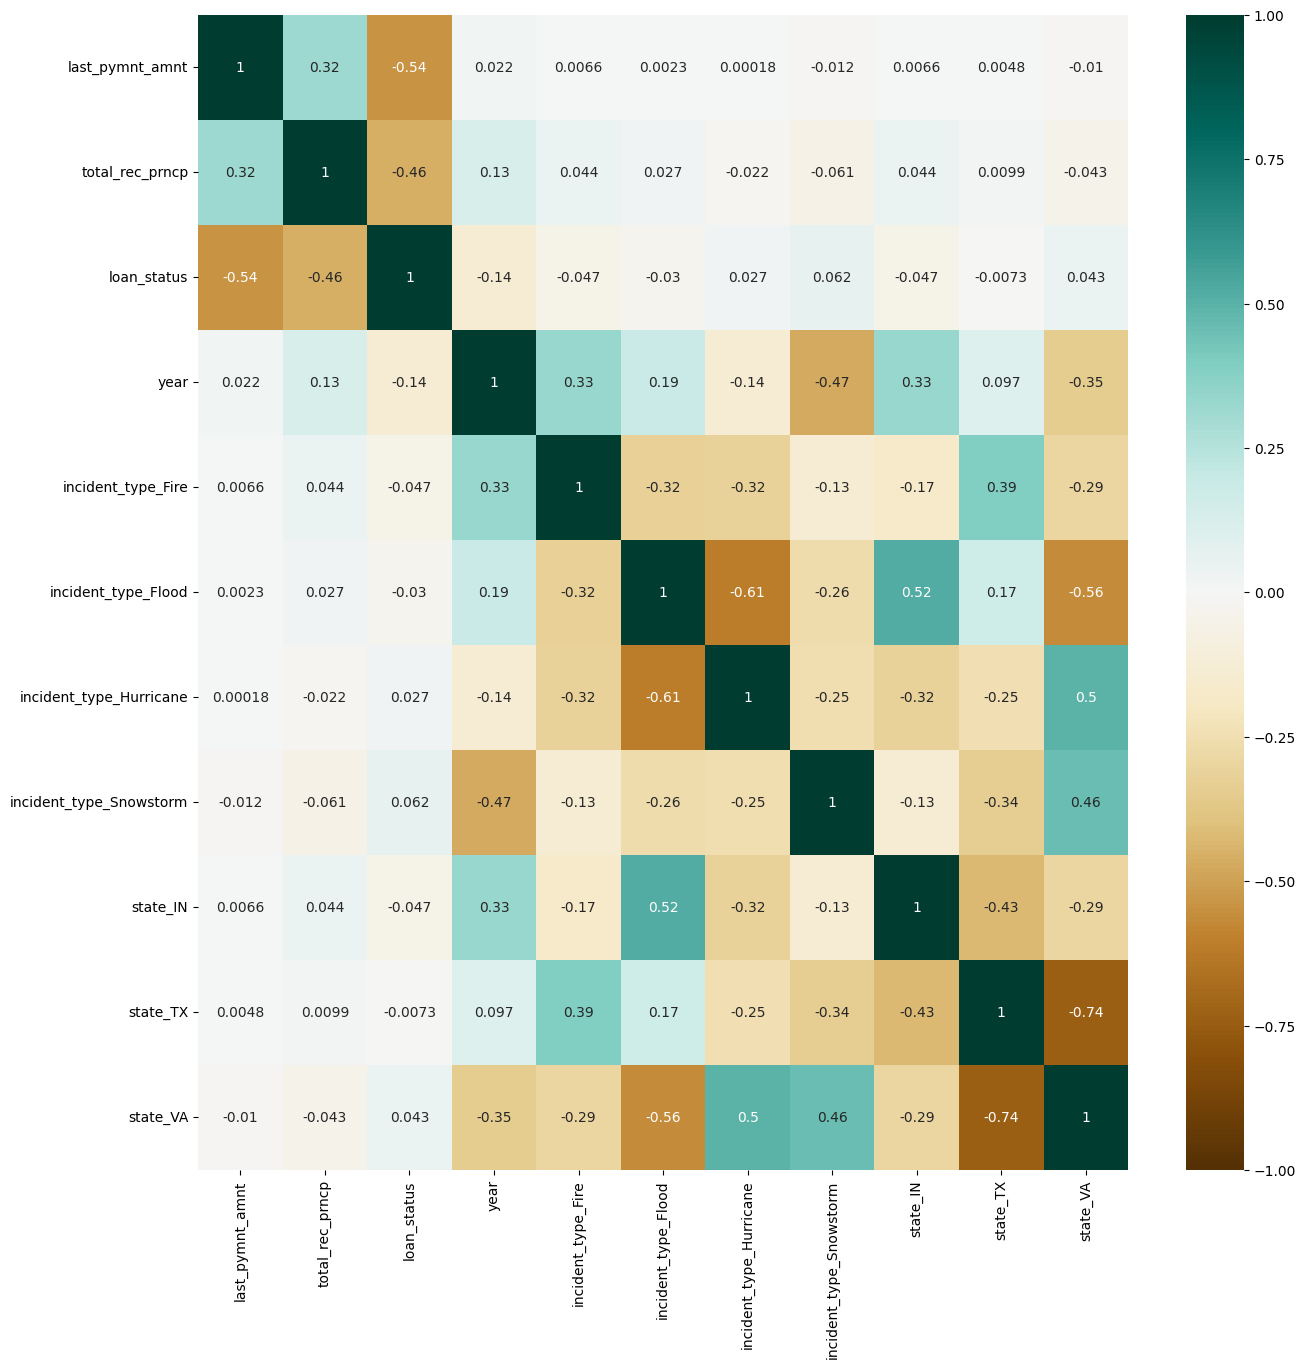

In [57]:
corr = merged_df. corr()
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar=True)
plt.show()

## Correlation Matrix on correlated pairs

In [58]:
# Find features that are correlated
correlated_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)): 
        col1 = corr.columns[i]
        col2 = corr.columns[j]
        corr_value = corr.iloc[i, j]
        correlated_pairs.append((col1, col2, corr_value))

# Print out correlated pairs with their correlation coefficient
print("Correlated pairs with their correlation coefficient:")
for col1, col2, corr_value in correlated_pairs:
    print(f"{col1} and {col2} have a correlation of {corr_value:.2f}")

Correlated pairs with their correlation coefficient:
last_pymnt_amnt and total_rec_prncp have a correlation of 0.32
last_pymnt_amnt and loan_status have a correlation of -0.54
last_pymnt_amnt and year have a correlation of 0.02
last_pymnt_amnt and incident_type_Fire have a correlation of 0.01
last_pymnt_amnt and incident_type_Flood have a correlation of 0.00
last_pymnt_amnt and incident_type_Hurricane have a correlation of 0.00
last_pymnt_amnt and incident_type_Snowstorm have a correlation of -0.01
last_pymnt_amnt and state_IN have a correlation of 0.01
last_pymnt_amnt and state_TX have a correlation of 0.00
last_pymnt_amnt and state_VA have a correlation of -0.01
total_rec_prncp and loan_status have a correlation of -0.46
total_rec_prncp and year have a correlation of 0.13
total_rec_prncp and incident_type_Fire have a correlation of 0.04
total_rec_prncp and incident_type_Flood have a correlation of 0.03
total_rec_prncp and incident_type_Hurricane have a correlation of -0.02
total_rec_

## Correlation Matrix with the target variables

In [59]:
# Find features that are correlated with the target variable 'loan_status'
correlated_with_loan_status = []
for column in merged_df.columns:
    if column != 'loan_status':
        corr_value = merged_df['loan_status'].corr(merged_df[column])
        correlated_with_loan_status.append((column, corr_value))

# Print out correlated pairs with their correlation coefficient
for feature, corr_value in correlated_with_loan_status:
    print(f"{feature} and loan_status have a correlation of {corr_value:.2f}")

last_pymnt_amnt and loan_status have a correlation of -0.54
total_rec_prncp and loan_status have a correlation of -0.46
year and loan_status have a correlation of -0.14
incident_type_Fire and loan_status have a correlation of -0.05
incident_type_Flood and loan_status have a correlation of -0.03
incident_type_Hurricane and loan_status have a correlation of 0.03
incident_type_Snowstorm and loan_status have a correlation of 0.06
state_IN and loan_status have a correlation of -0.05
state_TX and loan_status have a correlation of -0.01
state_VA and loan_status have a correlation of 0.04


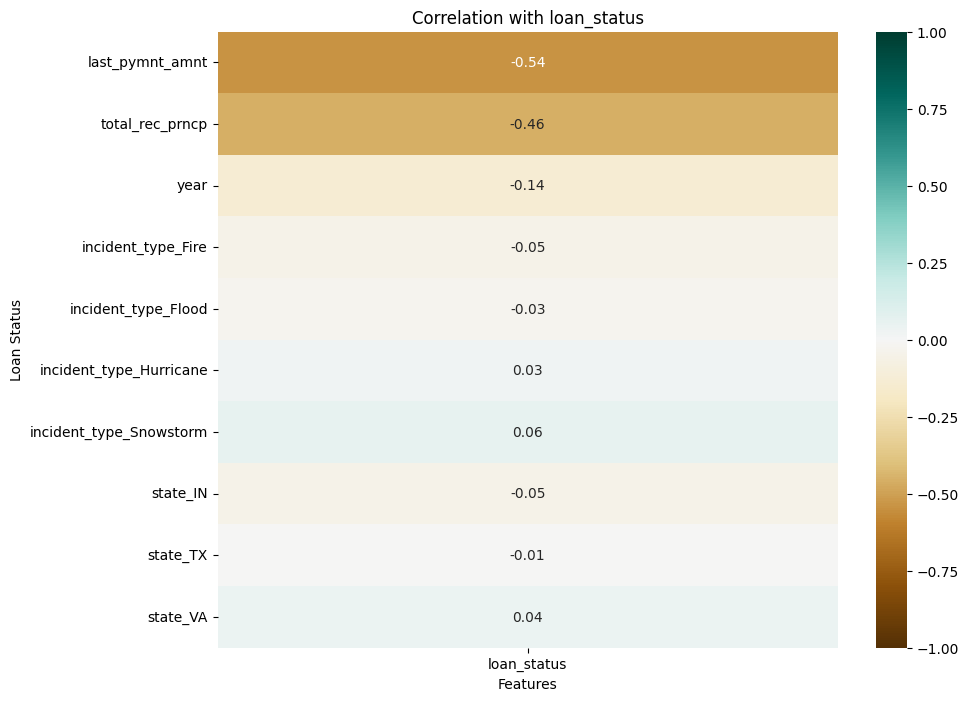

In [60]:
# Calculate correlations
correlation_matrix = merged_df.corr()

# Filter correlations with 'loan_status'
correlation_with_loan_status = correlation_matrix['loan_status'].drop('loan_status')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_loan_status.to_frame(), cmap='BrBG', annot=True, fmt=".2f", vmin=-1, vmax=1, cbar=True)
plt.title("Correlation with loan_status")
plt.xlabel("Features")
plt.ylabel("Loan Status")
plt.show()

# Predictive Model: Training, testing, and predicting

In [61]:
X = merged_df.drop('loan_status', axis=1)
y = merged_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [62]:
#Random forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=1234)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

In [63]:
y_pred = random_forest_model.predict(X_test)

In [64]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    126124
           1       0.96      0.95      0.95    115032

    accuracy                           0.96    241156
   macro avg       0.96      0.96      0.96    241156
weighted avg       0.96      0.96      0.96    241156



## Feature Importance

In [65]:
#Get feature importances
importances = random_forest_model.feature_importances_

#Create a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

#Sort the DataFrame to see the most important features at the top
features_df.sort_values(by='Importance', ascending=False, inplace=True)

print(features_df)

                   Feature  Importance
0          last_pymnt_amnt    0.537847
1          total_rec_prncp    0.450717
2                     year    0.008906
6  incident_type_Snowstorm    0.000849
3       incident_type_Fire    0.000451
7                 state_IN    0.000432
5  incident_type_Hurricane    0.000316
9                 state_VA    0.000211
8                 state_TX    0.000163
4      incident_type_Flood    0.000110


<function matplotlib.pyplot.show(close=None, block=None)>

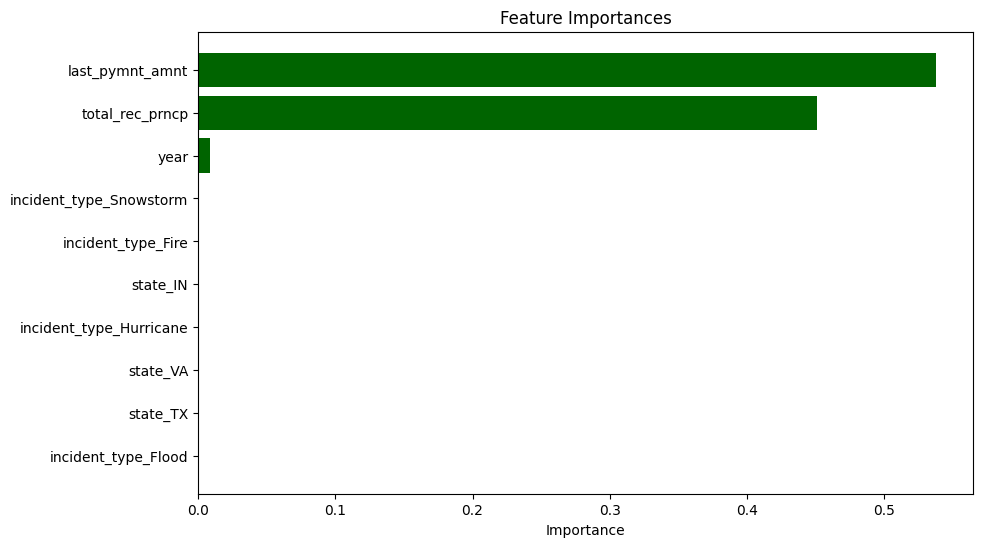

In [66]:
#Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='DarkGreen')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show

# Final Evaluation

**Feature Importance score for the Random Forest model:** 
* 'last_pymnt_amnt' contains a score of 0.54
* 'total_rec_prncp' contains a score of 0.45 
* 'year' contains a score of 0.009
* 'incident_type' contains a score between 0.0001 to 0.0009
* 'state' contains a score between 0.0001 to 0.0004

The feature importance score suggests that 'last_pymnt_amnt' and 'total_rec_prncp,' are the most important features for predicting loan defaults, with the natural disaster variables far behind.

**Research Question:**

The occurence of natural disasters in the United States from 2012 to 2019 cannot be used as a predictor for loan defaults, as there is no correlation between natural disasters and loan status in the dataset.

**Alternative Hypothesis (H1):**

This results in rejecting the Alternative Hypothesis (H1) as the evidence suggests that the occurrence of natural disasters in the United States from 2012 to 2019 is not significant.

**Null Hypothesis (H0):**

We accept the Null Hypothesis (H0), as the evidence supports the conclusion that natural disasters in the specified period have no predictive power for loan defaults.